# Sensitivity Analysis (GP)

This notebook contains code used to perform sensitivity analysis using GP.

In [12]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML
from copy import deepcopy
import random
import pickle
import GPy
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core.loop import UserFunctionWrapper
import matplotlib.pyplot as plt
from emukit.core import ContinuousParameter, DiscreteParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
import matplotlib.style as style

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

import warnings
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')

In [7]:
%run utilities.ipynb

## Experimentations

In [3]:
# Load data
over18 = load_csv("../data/bbc-pandemic/contact_distributions_o18.csv")
under18 = load_csv("../data/bbc-pandemic/contact_distributions_u18.csv")

### ANOVA of all variables 

The fourteen variables include general, policy, and compliance factors. We observed their contribution to the simulator function computing the effective *R* rate.

In [295]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = list(range(2, 14))
delay_domain = [i for i in range(8)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('home_sar', *reduced_variable_domain),
           ContinuousParameter('work_sar', *reduced_variable_domain),
           ContinuousParameter('other_sar', *reduced_variable_domain),
           ContinuousParameter('p_under18', *variable_domain),
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           DiscreteParameter('testing_delay', delay_domain), 
           DiscreteParameter('app_trace_delay', delay_domain), 
           DiscreteParameter('manual_trace_delay', delay_domain), 
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('max_contacts', max_contacts_domain),
           ContinuousParameter('compliance', *variable_domain), 
           ContinuousParameter('app_coverage', *variable_domain),               
           ])

#### GP Monte Carlo

In [9]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_all(x)
model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 0.8450129201879477


In [10]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_all, 10)

Optimization restart 1/1, f = 0.8450129201879477



Optimization restart 1/1, f = -0.4166233366302263



Optimization restart 1/1, f = -1.677371601184868



Optimization restart 1/1, f = -2.6252051726458276



Optimization restart 1/1, f = -0.07736100553118952



Optimization restart 1/1, f = 1.612136564158181



Optimization restart 1/1, f = 0.5791013170760753



Optimization restart 1/1, f = 0.5042426351341991



Optimization restart 1/1, f = 9.884495575108641



Optimization restart 1/1, f = 9.962752188444249



Optimization restart 1/1, f = 9.777118885151303


In [14]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [ ]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_all, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

In [ ]:
# ## Main effects
# fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

# main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
# main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_gp_plot
#     }

# pd.DataFrame(d).plot(kind='bar', ax=ax)

# # Label
# ax.set_ylabel('% of explained output variance', fontsize=13)
# ax.set_xlabel('All factors', fontsize=13)
# ax.set_facecolor("white")

# # Despine
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(0)

# # Ticks
# ax.tick_params(axis='both', which='major', labelsize=11)
# ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# # Legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
#            bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
#           prop={'size': 12})

# # Grid
# plt.grid(False)
# ax.yaxis.grid()

# plt.show()

In [ ]:
# ## Total effects
# fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

# total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# # total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_gp_plot
#     }

# pd.DataFrame(d).plot(kind='bar', ax=ax)

# # Label
# ax.set_ylabel('% of explained output variance', fontsize=13)
# ax.set_facecolor("white")
# ax.set_xlabel('All factors', fontsize=13)

# # Despine
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(0)

# # Ticks
# ax.tick_params(axis='both', which='major', labelsize=11)
# ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# # Legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
#            bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
#           prop={'size': 12})

# # Grid
# plt.grid(False)
# ax.yaxis.grid()

# plt.show()

In [ ]:
# ## Save experiment results
# d = {
#         'total_effects_gp': total_effects_gp_plot,
#         'total_effects': total_effects_plot,
#         'main_effects_gp': main_effects_gp_plot,
#         'main_effects': main_effects_plot
#     }

# pd.DataFrame(d).to_csv("../results/gp-policy.csv")

### ANOVA of compliance factor variables

The compliance factor variables, including app_coverage and compliance. We observed their contribution to the simulator function computing the effective *R* rate.

In [8]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = list(range(2, 14))
delay_domain = [i for i in range(8)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('compliance', *variable_domain), 
           ContinuousParameter('app_coverage', *variable_domain), 
           ])

#### GP Monte Carlo

In [9]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_compliance(x)
model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 0.8450129201879477


In [10]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_compliance, 10)

Optimization restart 1/1, f = 0.8450129201879477



Optimization restart 1/1, f = -0.4166233366302263



Optimization restart 1/1, f = -1.677371601184868



Optimization restart 1/1, f = -2.6252051726458276



Optimization restart 1/1, f = -0.07736100553118952



Optimization restart 1/1, f = 1.612136564158181



Optimization restart 1/1, f = 0.5791013170760753



Optimization restart 1/1, f = 0.5042426351341991



Optimization restart 1/1, f = 9.884495575108641



Optimization restart 1/1, f = 9.962752188444249



Optimization restart 1/1, f = 9.777118885151303


In [14]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [52]:
num_mc = 100
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_compliance, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

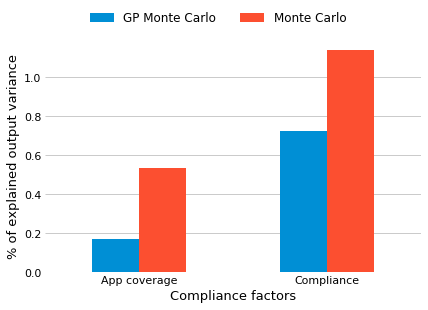

In [53]:
## Main effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

d = {
        'GP Monte Carlo': main_effects_gp_plot,
        'Monte Carlo': main_effects_plot
    }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")
ax.set_xlabel('Compliance factors', fontsize=13)

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

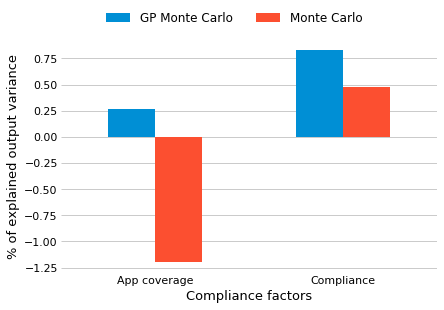

In [54]:
## Total effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

d = {
        'GP Monte Carlo': total_effects_gp_plot,
        'Monte Carlo': total_effects_plot
    }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")
ax.set_xlabel('Compliance factors', fontsize=13)

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

In [55]:
## Save experiment results
d = {
        'total_effects_gp': total_effects_gp_plot,
        'total_effects': total_effects_plot,
        'main_effects_gp': main_effects_gp_plot,
        'main_effects': main_effects_plot
    }

pd.DataFrame(d).to_csv("../results/gp-compliance.csv")

### ANOVA of general factor variables

The general factor variables, including secondary attack rates and probability of case under 18. We observed their contribution to the simulator function computing the effective *R* rate.

In [289]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = list(range(2, 14))
delay_domain = [i for i in range(8)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('home_sar', *reduced_variable_domain),
           ContinuousParameter('work_sar', *reduced_variable_domain),
           ContinuousParameter('other_sar', *reduced_variable_domain),
           ContinuousParameter('p_under18', *variable_domain),
           ])

#### GP Monte Carlo

In [9]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_general(x)
model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 0.8450129201879477


In [10]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_general, 10)

Optimization restart 1/1, f = 0.8450129201879477



Optimization restart 1/1, f = -0.4166233366302263



Optimization restart 1/1, f = -1.677371601184868



Optimization restart 1/1, f = -2.6252051726458276



Optimization restart 1/1, f = -0.07736100553118952



Optimization restart 1/1, f = 1.612136564158181



Optimization restart 1/1, f = 0.5791013170760753



Optimization restart 1/1, f = 0.5042426351341991



Optimization restart 1/1, f = 9.884495575108641



Optimization restart 1/1, f = 9.962752188444249



Optimization restart 1/1, f = 9.777118885151303


In [14]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [ ]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_general, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

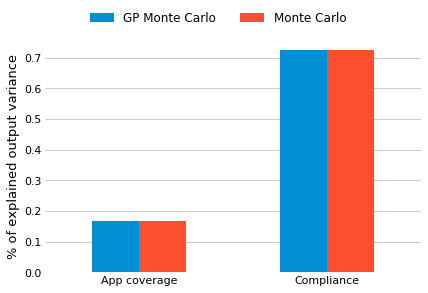

In [49]:
## Main effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

d = {
        'GP Monte Carlo': main_effects_gp_plot,
        'Monte Carlo': main_effects_gp_plot
    }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_xlabel('General factors', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

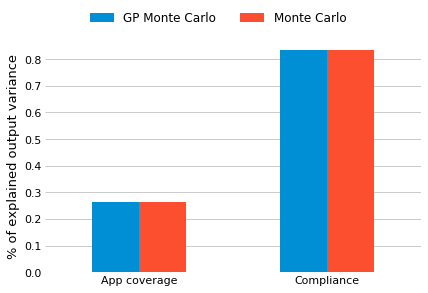

In [50]:
## Total effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

d = {
        'GP Monte Carlo': total_effects_gp_plot,
        'Monte Carlo': total_effects_gp_plot
    }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_xlabel('General factors', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

In [ ]:
## Save experiment results
d = {
        'total_effects_gp': total_effects_gp_plot,
        'total_effects': total_effects_plot,
        'main_effects_gp': main_effects_gp_plot,
        'main_effects': main_effects_plot
    }

pd.DataFrame(d).to_csv("../results/gp-general.csv")

### ANOVA of policy factor variables

The policy factor variables. We observed their contribution to the simulator function computing the effective *R* rate.

In [284]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(0, 2)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           DiscreteParameter('testing_delay', delay_domain), 
           DiscreteParameter('app_trace_delay', delay_domain), 
           DiscreteParameter('manual_trace_delay', delay_domain), 
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('max_contacts', max_contacts_domain), 
           ])

#### GP Monte Carlo

In [9]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_policy(x)
model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 0.8450129201879477


In [10]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_policy, 10)

Optimization restart 1/1, f = 0.8450129201879477



Optimization restart 1/1, f = -0.4166233366302263



Optimization restart 1/1, f = -1.677371601184868



Optimization restart 1/1, f = -2.6252051726458276



Optimization restart 1/1, f = -0.07736100553118952



Optimization restart 1/1, f = 1.612136564158181



Optimization restart 1/1, f = 0.5791013170760753



Optimization restart 1/1, f = 0.5042426351341991



Optimization restart 1/1, f = 9.884495575108641



Optimization restart 1/1, f = 9.962752188444249



Optimization restart 1/1, f = 9.777118885151303


In [14]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [ ]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_policy, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

In [ ]:
# ## Main effects
# fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

# main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
# main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_gp_plot
#     }

# pd.DataFrame(d).plot(kind='bar', ax=ax)

# # Label
# ax.set_ylabel('% of explained output variance', fontsize=13)
# ax.set_xlabel('Policy factors', fontsize=13)
# ax.set_facecolor("white")

# # Despine
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(0)

# # Ticks
# ax.tick_params(axis='both', which='major', labelsize=11)
# ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# # Legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
#            bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
#           prop={'size': 12})

# # Grid
# plt.grid(False)
# ax.yaxis.grid()

# plt.show()

In [ ]:
# ## Total effects
# fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

# total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# # total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_gp_plot
#     }

# pd.DataFrame(d).plot(kind='bar', ax=ax)

# # Label
# ax.set_ylabel('% of explained output variance', fontsize=13)
# ax.set_xlabel('Policy factors', fontsize=13)
# ax.set_facecolor("white")

# # Despine
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(0)

# # Ticks
# ax.tick_params(axis='both', which='major', labelsize=11)
# ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# # Legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
#            bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
#           prop={'size': 12})

# # Grid
# plt.grid(False)
# ax.yaxis.grid()

# plt.show()

In [ ]:
# ## Save experiment results
# d = {
#         'total_effects_gp': total_effects_gp_plot,
#         'total_effects': total_effects_plot,
#         'main_effects_gp': main_effects_gp_plot,
#         'main_effects': main_effects_plot
#     }

# pd.DataFrame(d).to_csv("../results/gp-policy.csv")

### ANOVA of WFH and GTS

We observed their contribution to the simulator function computing the effective *R* rate.

In [284]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(0, 2)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           ])

#### GP Monte Carlo

In [9]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_wfh(x)
model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 0.8450129201879477


In [10]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_wfh, 10)

Optimization restart 1/1, f = 0.8450129201879477



Optimization restart 1/1, f = -0.4166233366302263



Optimization restart 1/1, f = -1.677371601184868



Optimization restart 1/1, f = -2.6252051726458276



Optimization restart 1/1, f = -0.07736100553118952



Optimization restart 1/1, f = 1.612136564158181



Optimization restart 1/1, f = 0.5791013170760753



Optimization restart 1/1, f = 0.5042426351341991



Optimization restart 1/1, f = 9.884495575108641



Optimization restart 1/1, f = 9.962752188444249



Optimization restart 1/1, f = 9.777118885151303


In [14]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [ ]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_wfh, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

In [ ]:
# ## Main effects
# fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

# main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
# main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_gp_plot
#     }

# pd.DataFrame(d).plot(kind='bar', ax=ax)

# # Label
# ax.set_ylabel('% of explained output variance', fontsize=13)
# ax.set_xlabel('Policy factors', fontsize=13)
# ax.set_facecolor("white")

# # Despine
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(0)

# # Ticks
# ax.tick_params(axis='both', which='major', labelsize=11)
# ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# # Legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
#            bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
#           prop={'size': 12})

# # Grid
# plt.grid(False)
# ax.yaxis.grid()

# plt.show()

In [ ]:
# ## Total effects
# fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

# total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# # total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_gp_plot
#     }

# pd.DataFrame(d).plot(kind='bar', ax=ax)

# # Label
# ax.set_ylabel('% of explained output variance', fontsize=13)
# ax.set_xlabel('Policy factors', fontsize=13)
# ax.set_facecolor("white")

# # Despine
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(0)

# # Ticks
# ax.tick_params(axis='both', which='major', labelsize=11)
# ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# # Legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
#            bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
#           prop={'size': 12})

# # Grid
# plt.grid(False)
# ax.yaxis.grid()

# plt.show()

In [ ]:
# ## Save experiment results
# d = {
#         'total_effects_gp': total_effects_gp_plot,
#         'total_effects': total_effects_plot,
#         'main_effects_gp': main_effects_gp_plot,
#         'main_effects': main_effects_plot
#     }

# pd.DataFrame(d).to_csv("../results/gp-wfh.csv")